In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



# pre processing
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
#from imblearn.under_sampling import TomekLinks # down sampling
#from imblearn.over_sampling import SMOTE # up sampling


# model selection
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# Model Validation 
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# statistical testing
from scipy.stats import f_oneway
from scipy import stats

sns.set_style('whitegrid')

%matplotlib inline

In [4]:
# import data
us_shape = gpd.read_file('../../src/data/cb_2018_us_state_500k.shp')

df = pd.read_csv('../../src/csv/final_dataframe_graphing.csv')
df_model = pd.read_csv('../../src/csv/final_dataframe.csv')
us_shape.STATEFP = us_shape.STATEFP.astype(int)


# Filtered out the noise by subtracting the mean of the state target.

In [24]:

target_sum_state = df.groupby(["GESTFIPS"]).target.sum().reset_index()

us_shape_target = us_shape.merge(target_sum_state, left_on='STATEFP', right_on='GESTFIPS', how='inner')
us_shape_target.target = us_shape_target.target/us_shape_target.target.sum() * 100

In [27]:
us_shape_target.target = us_shape_target.target - us_shape_target.target.median()
us_shape_target.target = [x if x > 0 else 0 for x in us_shape_target.target]

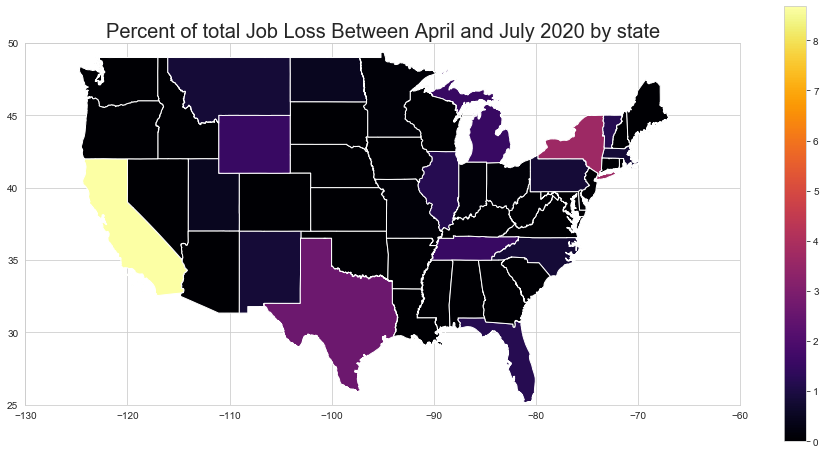

In [28]:
merged = us_shape_target.copy()
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

fig, ax = plt.subplots(figsize = (16,8))
merged.plot(ax=ax,
                         alpha = 1,
                         column='target',
                         cmap = 'inferno',
                         legend=True)
ax.set_ylim(25,50)
ax.set_xlim(-130,-60)
ax.set_title("Percent of total Job Loss Between April and July 2020 by state", size=20);
fig.savefig('../../images/job_loss_state.png', bbox_inches='tight')

# Covid data by state

In [12]:
target_sum_delta = df.groupby(["GESTFIPS"]).case_delta.sum().reset_index()


us_shape_delta = us_shape.merge(target_sum_delta, left_on='STATEFP', right_on='GESTFIPS', how='inner')


us_shape_delta.case_delta = us_shape_delta.case_delta/us_shape_delta.case_delta.sum() * 100

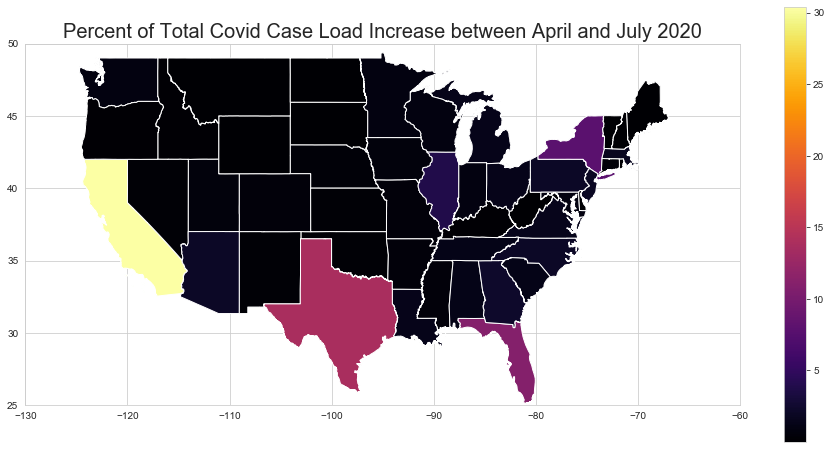

In [15]:
merged = us_shape_delta.copy()
merged['coords'] = merged['geometry'].apply(lambda x: x.representative_point().coords[:])
merged['coords'] = [coords[0] for coords in merged['coords']]

fig, ax = plt.subplots(figsize = (16,8))
merged.plot(ax=ax,
                         alpha = 1,
                         column='case_delta',
                         cmap = 'inferno',
                         legend=True)

ax.set_ylim(25,50)
ax.set_xlim(-130,-60)

# for idx, row in merged.iterrows():
#     plt.annotate(s=row['gov'], xy=row['coords'],horizontalalignment='center', color='white')
    
ax.set_title("Percent of Total Covid Case Load Increase between April and July 2020", size=20);
fig.savefig('../../images/case_delta_percent.png', bbox_inches='tight')

In [31]:
X = df_model.drop(columns = ['target', 'population'])
y = df_model.target

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

logReg = LogisticRegression(class_weight='balanced', solver='saga', penalty='l2', C=0.015)

logReg.fit(X_scaled, y)
y_hat = logReg.predict(X_scaled)
cmatrix = confusion_matrix(y,y_hat)
print(classification_report(y, y_hat))

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


              precision    recall  f1-score   support

           0       0.96      0.71      0.82      3622
           1       0.15      0.67      0.25       281

   micro avg       0.71      0.71      0.71      3903
   macro avg       0.56      0.69      0.53      3903
weighted avg       0.91      0.71      0.78      3903



/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


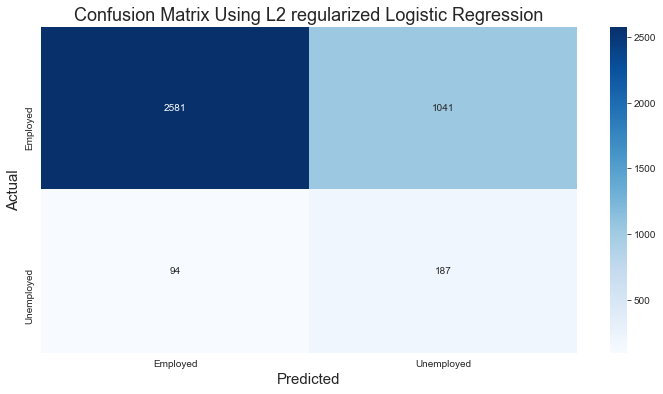

In [32]:
fig, ax = plt.subplots(figsize = (12,6))
sns.heatmap(cmatrix, annot=True, fmt='g', ax=ax, cmap='Blues')
ax.set_xticklabels(['Employed', 'Unemployed'])
ax.set_yticklabels(['Employed', 'Unemployed'])
ax.set_ylabel('Actual', size=15)
ax.set_xlabel('Predicted', size=15)

ax.set_title('Confusion Matrix Using L2 regularized Logistic Regression', size =18)

fig.savefig('../../images/confusion_matrix.png', bbox_inches='tight')

Text(0, 0.5, 'Frequency')

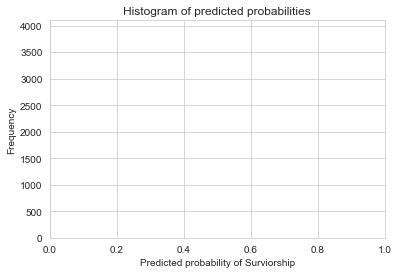

In [46]:
y_pred_prob = logReg.predict_proba(X)[:, 1]
plt.hist(y_pred_prob, bins=30,)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Surviorship')
plt.ylabel('Frequency')

In [30]:
fpr, tpr, thresholds =roc_curve(y, y_hat)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Titanic classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

NameError: name 'y' is not defined

In [29]:
fpr

NameError: name 'fpr' is not defined

In [63]:
coef_list = sorted(zip(X.columns.to_list(),logReg.coef_[0]), key=lambda x: x[1], reverse=True)
target_feature = [x[0] for x in coef_list][:10]
target_feature

['PRTAGE',
 'PTDTRACE_3',
 'case_delta',
 'PENATVTY',
 'PRAGNA',
 'PEMJOT',
 'PRMJOCC1_4',
 'PRMJIND1_6',
 'PRMJIND1_10',
 'HRNUMHOU']

In [ ]:
feature_names = [
    'Age',
    'Indiginous Descent',
    'Coronavirus Case Increase',
    'Born in the US',
    'Agricultural work force',
    'More than one Job',
    'Retail Workers',
    'Transportation Workers',
    'Education workers',
    ''
]

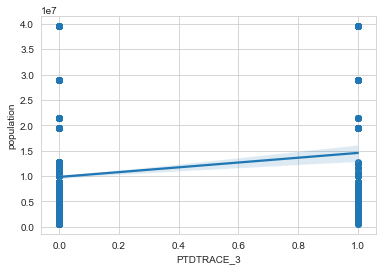

In [59]:
sns.regplot(data=df, x='PTDTRACE_3', y='population')